In [80]:
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.cm as cm

In [81]:

# Load a pre-trained ViT model and feature extractor
model_name = '/Users/julio/Documents/PMM/Codigos/Test1/Classification-ViT/SavedModels/ViT-base-patch16-224_F/checkpoint-4512'
processor = ViTImageProcessor.from_pretrained(model_name, do_rescale=False)
model = ViTForImageClassification.from_pretrained(model_name, attn_implementation='eager')

# Run an image through the pipline
path_image = '/Users/julio/Library/Mobile Documents/com~apple~CloudDocs/Downloads/image.png'
image = Image.open(path_image).convert("RGB")
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

# Getting the attentions
attentions = outputs.attentions 

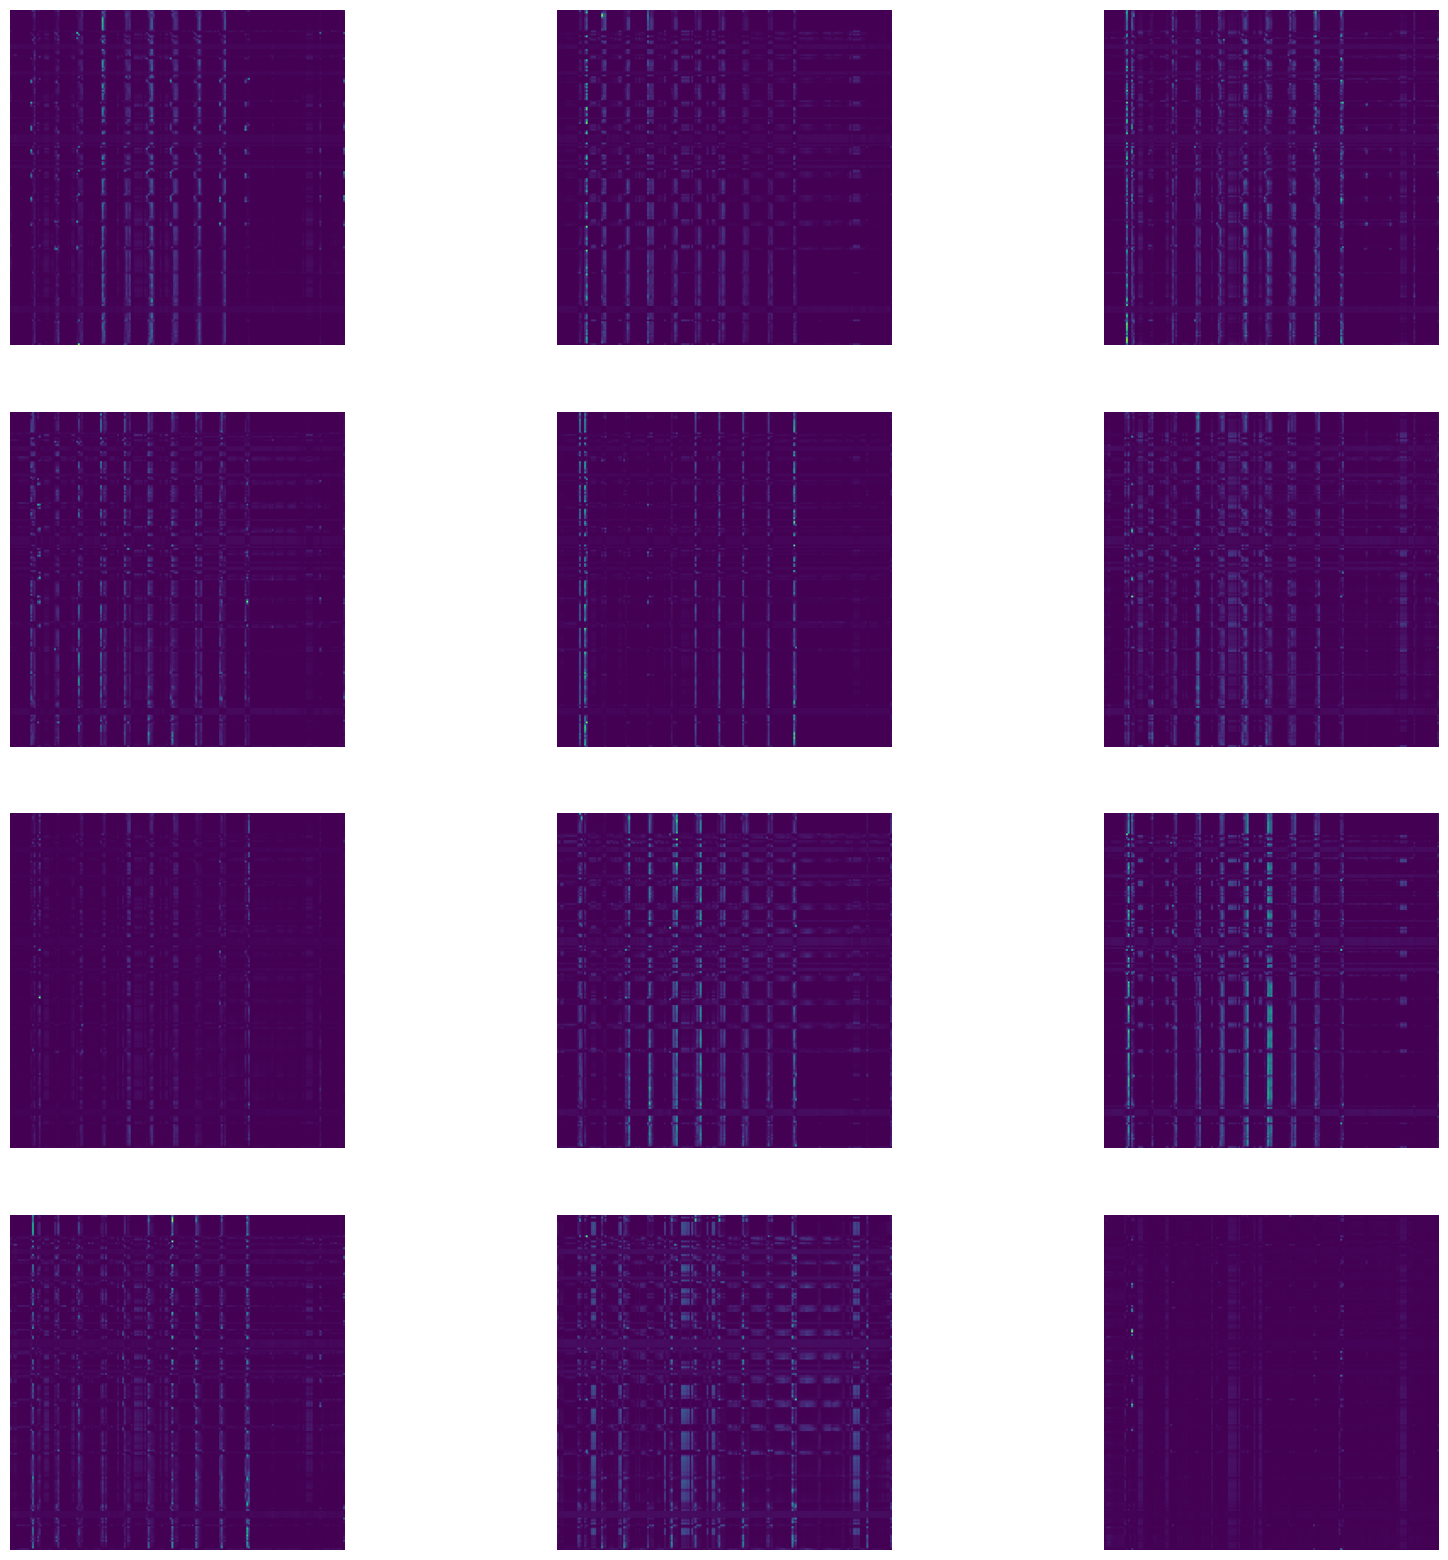

In [82]:
ig, axs = plt.subplots(4, 3, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(attentions[-1][0, i, :, :].detach().cpu().numpy())
    ax.axis('off')

In [83]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

In [84]:
rollout = attention_rollout(attentions)
num_of_patches = (224 // 16) ** 2
cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))

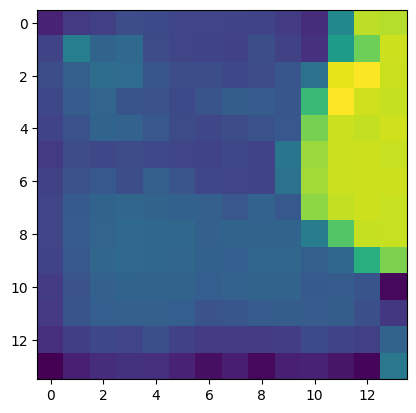

In [85]:
plt.imshow(cls_attention.detach().cpu().numpy())

In [86]:
# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# Resize and blur the attention map
cls_attention_resized = Image.fromarray((cls_attention.detach().cpu().numpy() * 255).astype(np.uint8)).resize((224, 224), resample=Image.BICUBIC)
cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))

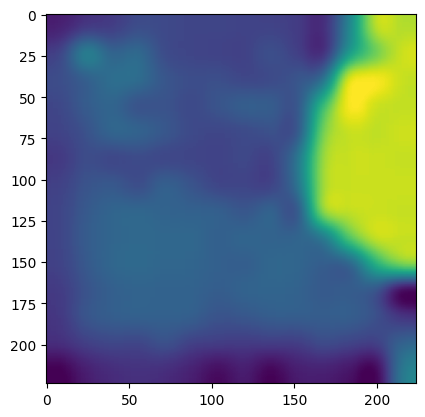

In [87]:
plt.imshow(cls_attention_resized)

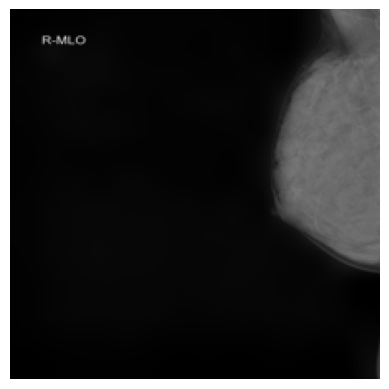

In [88]:
# Convertir el mapa de atención a escala de grises y agregar un canal alfa para la transparencia
attention_overlay = cls_attention_resized.convert("L")  # Convertir a escala de grises
attention_overlay = attention_overlay.point(lambda x: x * 0.5)  # Ajustar la intensidad del overlay (0.5 es 50% de opacidad)
attention_overlay = Image.merge("RGBA", [attention_overlay] * 3 + [attention_overlay])  # Añadir canal alfa

# Redimensionar la imagen original al tamaño del overlay (si es necesario)
image_resized = image.resize(attention_overlay.size)

# Combinar la imagen original y el overlay
blended_image = Image.alpha_composite(image_resized.convert("RGBA"), attention_overlay)

# Mostrar el resultado
plt.imshow(blended_image)
plt.axis("off")
plt.show()

In [89]:
# Convert the attention map to RGBA
cls_attention_colored = np.array(cls_attention_resized.convert("L"))
cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)

# Adjust the alpha channel to control brightness
cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
cls_attention_colored_img.putalpha(100)  # Adjust alpha for blending (lower value for darker overlay)

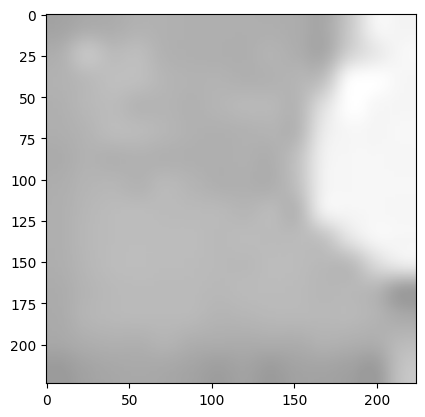

In [90]:
plt.imshow(cls_attention_colored_img)

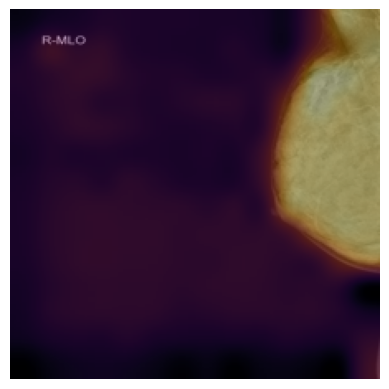

In [95]:
# Aplicar un colormap al mapa de atención para darle color
attention_colored = np.array(cls_attention_resized)
attention_colored = cm.inferno(attention_colored / 255.0)  # Aplicar colormap 'jet' para colores
attention_colored = (attention_colored[:, :, :3] * 255).astype(np.uint8)  # Quitar canal alfa del colormap y escalar a 0-255
attention_colored = Image.fromarray(attention_colored).convert("RGBA")

# Ajustar la opacidad del overlay de atención (opcional)
alpha = 100  # Valor de opacidad, entre 0 (transparente) y 255 (opaco)
attention_colored.putalpha(alpha)

# Redimensionar la imagen original al tamaño del overlay (si es necesario)
image_resized = image.resize(attention_colored.size).convert("RGBA")

# Combinar la imagen original en escala de grises y el overlay de atención con color
blended_image = Image.alpha_composite(image_resized, attention_colored)

# Mostrar el resultado
plt.imshow(blended_image)
plt.axis("off")
plt.show()

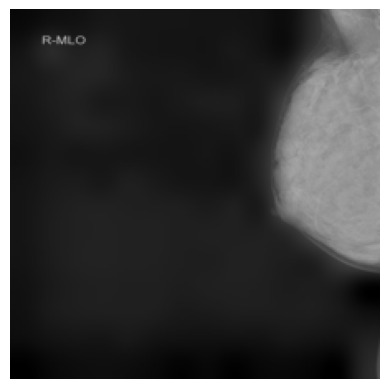

In [92]:
# Combinar la imagen original en escala de grises y el overlay de atención con color
blended_image = Image.alpha_composite(image_resized, cls_attention_colored_img)

# Mostrar el resultado
plt.imshow(blended_image)
plt.axis("off")
plt.show()